In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from Plot_tools import *    

import cartopy.crs as ccrs
import cartopy.feature as cfeature


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def add_fhour(ds):

        filename = ds.encoding["source"].split("_")

        init_time = int(filename[-2])
        fhour     = int(filename[-1][-5:-3])

        ds.coords['fhour'] = fhour
        ds.coords['init_time'] = init_time

        return ds
    
def open_mfdataset_list(run_dir, pattern, model_type):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(run_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

def read_wrf(run_dir, pattern, model_type='wrf'):
        
    #ds   = open_mfdataset_list(run_dir, pattern, model_type)
    print(os.path.join(run_dir,pattern))
    ds   = xr.open_dataset(os.path.join(run_dir,pattern))

    if model_type == 'wrf':
        w    = ds.W.values
        u    = ds.U.values
        v    = ds.V.values
        z    = (ds.PH.values + ds.PHB.values) / 9.806

    else:
        w    = ds.w.values
        u    = ds.uReconstructZonal.values
        v    = ds.uReconstructMeridional.values
        z    = ds.zgrid.values
 
    return u,v,w, z

In [37]:

u0, v0, w0, z0 = read_wrf('/scratch/tajones/dart/FCST/20240508/1500/ENS_MEM_1/BASE_FIX', 'wrfout_d01_2024-05-08_18:00:00', 'wrf')
u1, v1, w1, z1 = read_wrf('/work/wicker/MPAS_Diagnostic_Tools', 'test_mpasit_01.restart.2024-05-08_18.00.00.nc', 'mpas')


/scratch/tajones/dart/FCST/20240508/1500/ENS_MEM_1/BASE_FIX/wrfout_d01_2024-05-08_18:00:00
/work/wicker/MPAS_Diagnostic_Tools/test_mpasit_01.restart.2024-05-08_18.00.00.nc


In [38]:
print(z0.max(), z0.min())
print(z1.max(), z1.min())

26623.973 17.278494
25226.088 24.767498


Text(0.5, 0.98, 'W distributions')

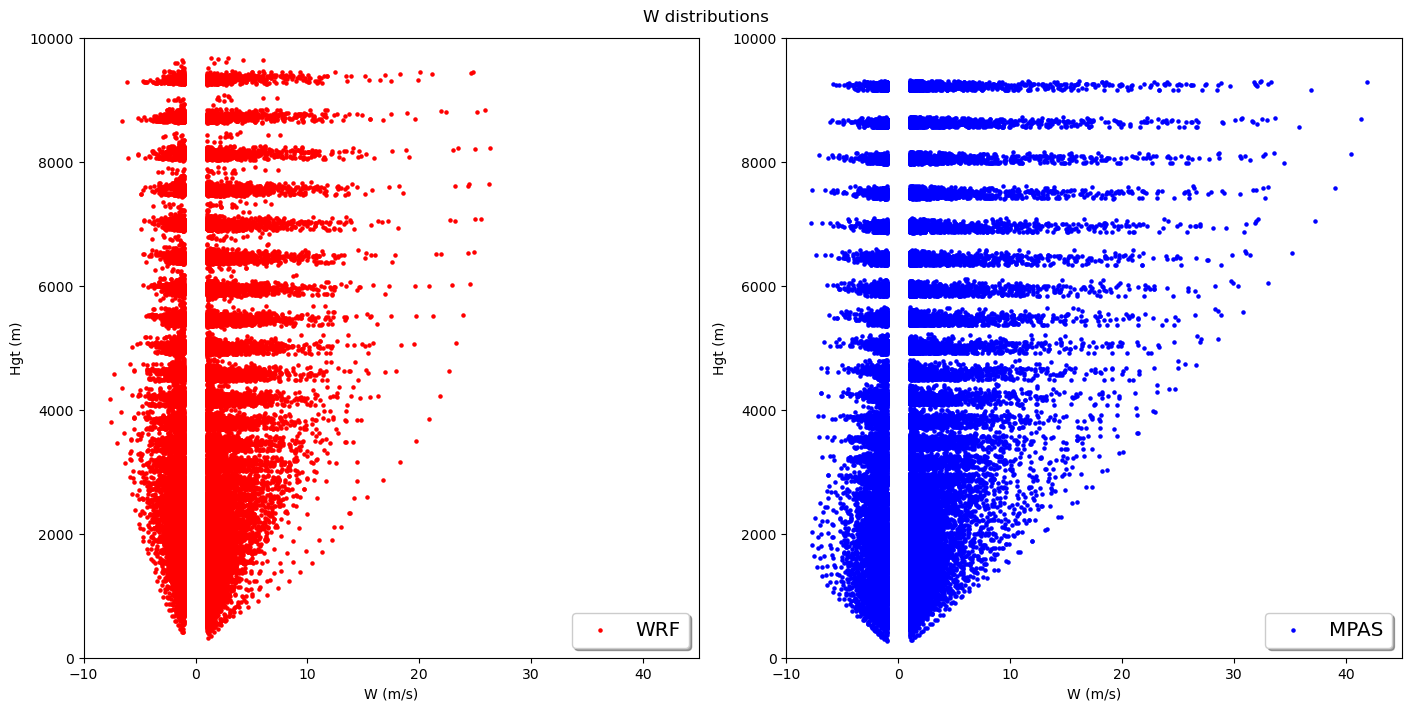

In [77]:
fig, ax = plt.subplots(1,2, constrained_layout=True,figsize=(14,7))

wmin = 1.0

w0_data = w0[0,0:40, 10:290, 10:290].flatten()
z0_data = z0[0,0:40, 10:290, 10:290].flatten()
w1_data = w1[0,0:40, 10:290, 10:290].flatten()
z1_data = z1[0,0:40, 10:290, 10:290].flatten()

w0_min = w0_data[np.abs(w0_data) >= wmin]
z0_min = z0_data[np.abs(w0_data) >= wmin]
w1_min = w1_data[np.abs(w1_data) >= wmin]
z1_min = z1_data[np.abs(w1_data) >= wmin]

ax[0].scatter(w0_min, z0_min, s=5, color='r', label='WRF')
legend = ax[0].legend(loc='lower right', shadow=True, fontsize='x-large')


ax[1].scatter(w1_min, z1_min, s=5, color='b', label='MPAS')
legend = ax[1].legend(loc='lower right', shadow=True, fontsize='x-large')
ax[0].set_xlim(-10,45.)
ax[0].set_ylim(0,10000)
ax[0].set_xlabel('W (m/s)')
ax[0].set_ylabel('Hgt (m)')
ax[1].set_xlim(-10,45.)
ax[1].set_ylim(0,10000)
ax[1].set_xlabel('W (m/s)')
ax[1].set_ylabel('Hgt (m)');

fig.suptitle('W distributions')

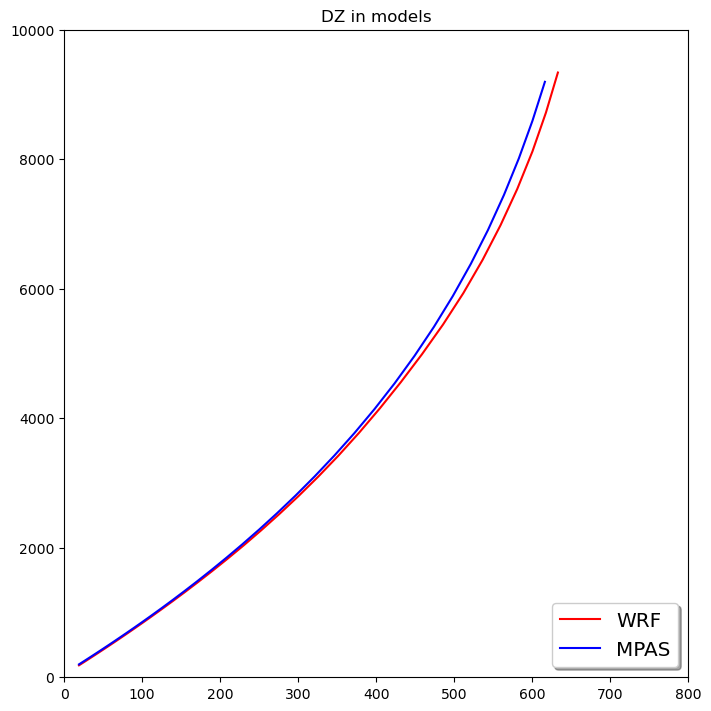

In [76]:
fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(7,7))

wmin = 1.0

z0_data = z0[0,0:40, 10:290, 10:290]
z1_data = z1[0,0:40, 10:290, 10:290]

dz0 = (z0[0,1:] - z0[0,:-1])[0:40, 10:290, 10:290]
dz1 = (z1[0,1:] - z1[0,:-1])[0:40, 10:290, 10:290]

ax.plot(dz0.mean(axis=(1,2)), z0_data.mean(axis=(1,2)), color='r', label='WRF')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')


ax.plot(dz1.mean(axis=(1,2)), z1_data.mean(axis=(1,2)), color='b', label='MPAS')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
ax.set_xlim(0,800)
ax.set_ylim(0,10000)
ax.set_title('DZ in models');
# ax[0].set_xlabel('DZ (m)')
# ax[0].set_ylabel('Hgt (m)')
# ax[1].set_xlim(-10,45.)
# ax[1].set_ylim(0,10000)
# ax[1].set_xlabel('W (m/s)')
# ax[1].set_ylabel('Hgt (m)');

0.612173 -0.86874866


Text(0.5, 1.0, 'W field at k = 20     Full Domain')

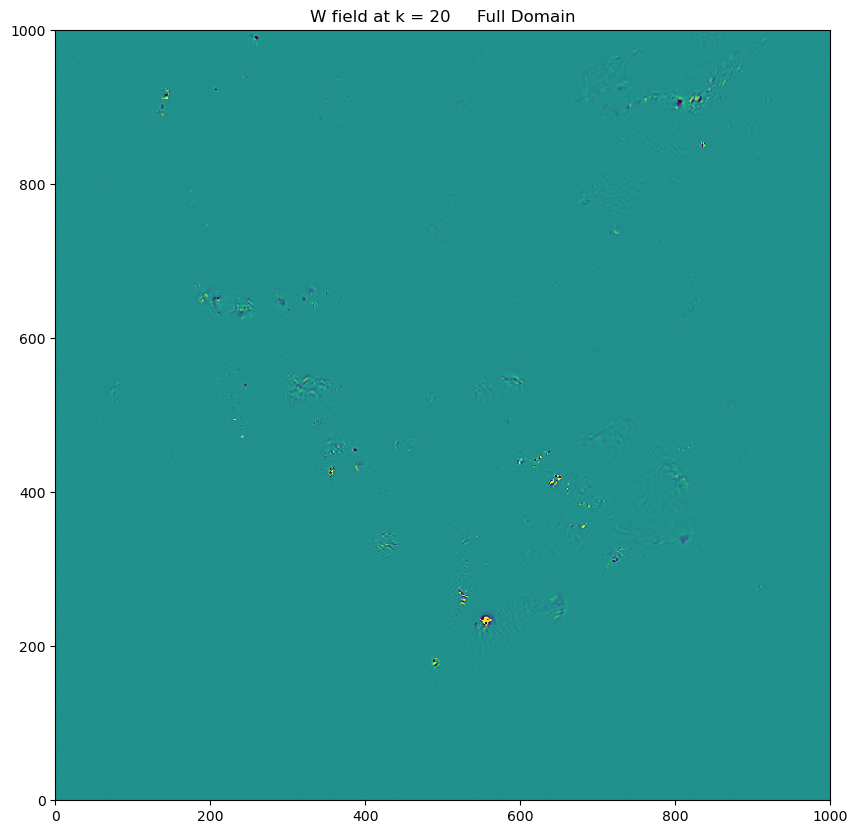

In [6]:
diff = w96 - w72

klevel = 20

print(diff[0,klevel].max(), diff[0,klevel].min())

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,10))

plot = axes.pcolormesh(10*diff[0,klevel], shading='auto', vmax=1, vmin=-1, cmap='viridis')

axes.set_title("W field at k = %d     Full Domain" % klevel)


0.5114174 -0.46195072


Text(0.5, 1.0, 'W field at k = 20   Zoomed Domain')

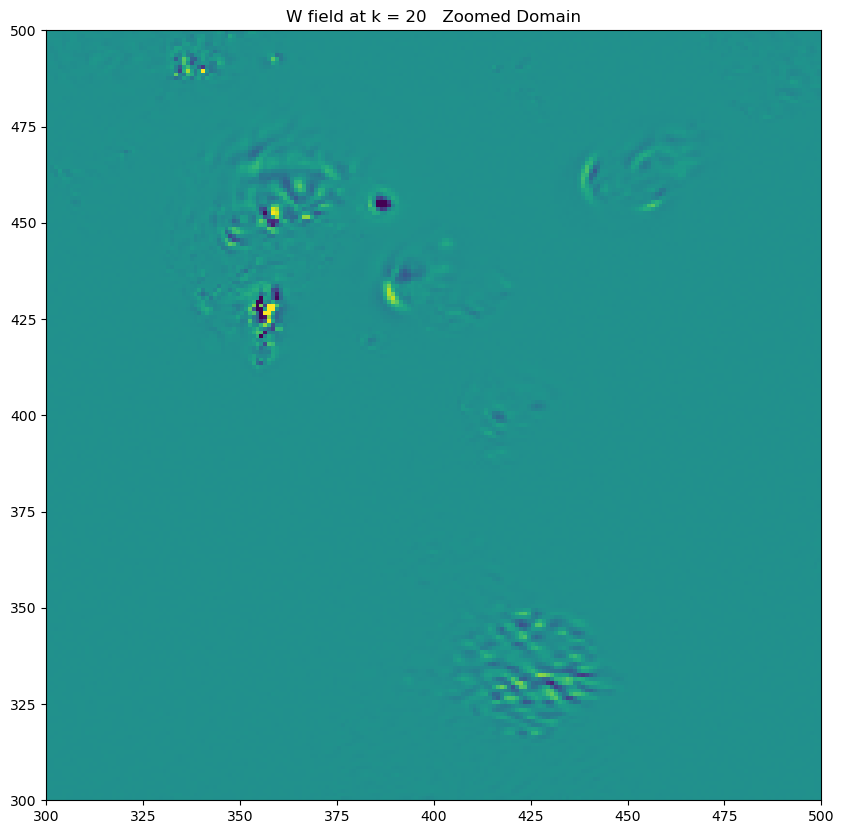

In [11]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,10))

print(diff[0,klevel,300:500,300:500].max(), diff[0,klevel,300:500,300:500].min())

plot = axes.pcolormesh(10*diff[0,klevel], shading='auto', vmax=1, vmin=-1, cmap='viridis')
axes.set_xlim(300,500)
axes.set_ylim(300,500)
axes.set_title("W field at k = %d   Zoomed Domain" % klevel)

In [25]:
u96, v96, w96, lats, lons = read_wrf('/work/wicker/WRF/WRF/run/wrf_72_noIEVA_3', 'wrfout_d01_2011-04-27_01:00:00', 'wrf')
u72, v72, w72, lats, lons = read_wrf('/work/wicker/WRF/WRF/run/wrf_72_noIEVA_31', 'wrfout_d01_2011-04-27_01:00:00', 'wrf')

diff = w96 - w72

0.5928126 -0.45535755


Text(0.5, 1.0, 'W field at k = 20   Zoomed Domain')

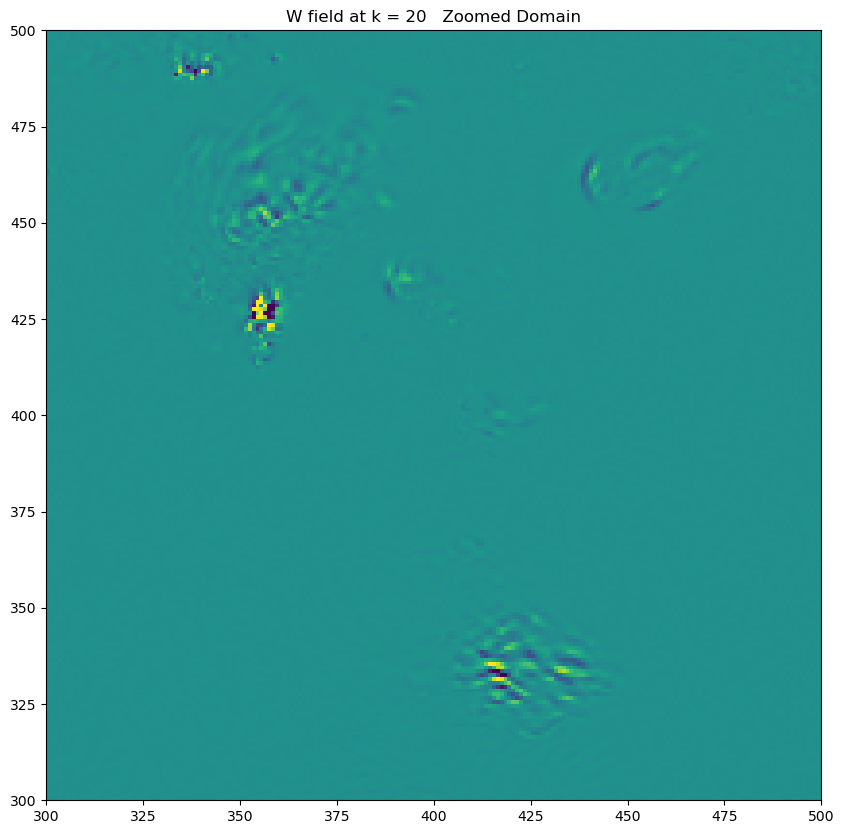

In [26]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,10))

print(diff[0,klevel,300:500,300:500].max(), diff[0,klevel,300:500,300:500].min())

plot = axes.pcolormesh(10*diff[0,klevel], shading='auto', vmax=1, vmin=-1, cmap='viridis')
axes.set_xlim(300,500)
axes.set_ylim(300,500)
axes.set_title("W field at k = %d   Zoomed Domain" % klevel)